<a href="https://colab.research.google.com/github/MahyarFardin/Monocular_depth_estimation_via_transfer_learning/blob/main/Monocular_depth_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#pip install kornia

#Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision as tv
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import DataLoader
from scipy import ndimage
import skimage
import glob
from PIL import Image
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from kornia.losses import ssim_loss

This part is used for loading data from kaggle

In [ ]:
# ! mkdir ~/.kaggle
# ! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d soumikrakshit/nyu-depth-v2
# ! mv "/content/nyu-depth-v2.zip" "/content/drive/MyDrive/depth"
# ! unzip "/content/drive/MyDrive/depth/nyu-depth-v2.zip" -d "/content/drive/MyDrive/depth/"

#Main Code

Importing data

In [4]:
#All of the constants in the code
BATCH_SIZE = 4
EPOCHS = 100

In [5]:
TRAIN_DIR = "/content/drive/MyDrive/depth/nyu_data/data/nyu2_train"
TEST_DIR = "/content/drive/MyDrive/depth/nyu_data/data/nyu2_test"

In [6]:
X_TRAIN_DIR = sorted(glob.glob(TRAIN_DIR+"/*/*.jpg"))
Y_TRAIN_DIR = sorted(glob.glob(TRAIN_DIR+"/*/*.png"))

X_TEST_DIR = sorted(glob.glob(TEST_DIR+"/*colors*"))
Y_TEST_DIR = sorted(glob.glob(TEST_DIR+"/*depth*"))

Finding unpaired data to remove!

In [8]:
print(len(X_TRAIN_DIR), len(Y_TRAIN_DIR))

20273 20273


In [9]:
print(len(X_TEST_DIR), len(Y_TEST_DIR))

654 654


In [ ]:
for i, j in zip(X_TRAIN_DIR, Y_TRAIN_DIR):
    if i.split("/")[-1][:-4] != j.split("/")[-1][:-4]:
        print(i)
        print(j)

In [ ]:
for i, j in zip(X_TEST_DIR, Y_TEST_DIR):
    if i.split("/")[-1][:5] != j.split("/")[-1][:5]:
        print(i)
        print(j)

In [7]:
class Channel_swap(torch.nn.Module):
    def forward(self, img):
        if img.size[-1] == 3 and np.random.uniform() > .5:
          r = img[:, :, 0]
          b = img[:, :, 2]
          img[:, :, 2] = r
          img[:, :, 0] = b
        return img

In [8]:
# our trainsformation including third channel swap + random horizontal flip

data_transform = tv.transforms.Compose([
    Channel_swap(),
    tv.transforms.RandomHorizontalFlip(p=0.5),
    tv.transforms.ToTensor()
])

In [9]:
# custom data loader

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        self.transforms = transforms

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx):
        imagePath = self.imagePaths[idx]
        image = Image.open(imagePath)
        mask = Image.open(self.maskPaths[idx])
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
        return (image, mask)

In [10]:
train_data = SegmentationDataset(X_TRAIN_DIR, Y_TRAIN_DIR, data_transform)
test_data = SegmentationDataset(X_TEST_DIR, Y_TEST_DIR, data_transform)

In [11]:
# displaying some random samples from dataset

def display_random_images(dataset, n = 10, display_shape= True, seed = None):
    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(10, 60))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        targ_image_adjust = targ_image.permute(1, 2, 0)
        targ_label_adjust = targ_label.permute(1, 2, 0)

        plt.subplot(n, 2, 2*i+1)
        plt.imshow(targ_image_adjust)

        plt.subplot(n, 2, 2*i+2)
        plt.imshow(targ_label_adjust)

        plt.axis("off")

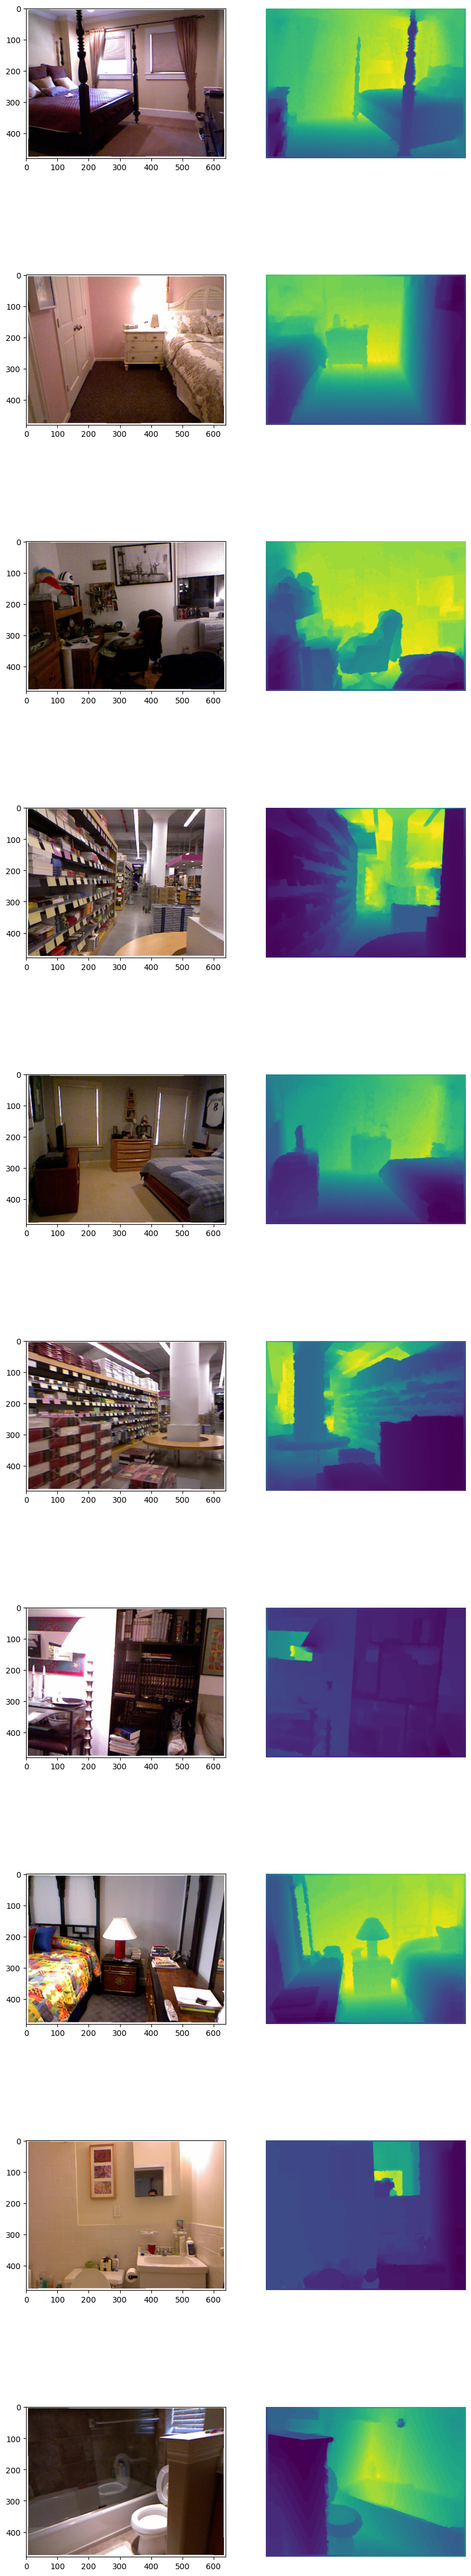

In [ ]:
display_random_images(train_data)

In [12]:
train_data = DataLoader(SegmentationDataset(X_TRAIN_DIR, Y_TRAIN_DIR, data_transform), batch_size = BATCH_SIZE, shuffle = True )
test_data = DataLoader(SegmentationDataset(X_TEST_DIR, Y_TEST_DIR, data_transform), batch_size = BATCH_SIZE * 2)

Model

In [23]:
# these are used as buffers of forward hooks

pool0, pool1, pool2, convolution0 = [], [], [], []

In [78]:
class Model(nn.Module):
    def __init__(self):
      super(Model, self).__init__()
      # our encoder is a pre-trained densenet 169
      self.encoder = models.densenet169(pretrained=True)

      # hooks were employed to have access to the outputs
      # of densenets middle layers to set skip connections
      global pool0, pool1, pool2, convolution0

      def hook_pool0(module, input, output):
        pool0.append(output)

      def hook_pool1(module, input, output):
        pool1.append(output)

      def hook_pool2(module, input, output):
        pool2.append(output)

      def hook_convolution0(module, input, output):
        convolution0.append(output)

      self.encoder.features.transition1.pool.register_forward_hook(hook_pool0)
      self.encoder.features.transition2.pool.register_forward_hook(hook_pool1)
      self.encoder.features.pool0.register_forward_hook(hook_pool2)
      self.encoder.features.conv0.register_forward_hook(hook_convolution0)

      # the paper implemented encoder untill the last conv 1*1
      self.encoder.features.denseblock4.denselayer32.conv2 = nn.Identity()

      # no need for classifier
      self.encoder.classifier = nn.Identity()

      # no training only transfer learning
      for param in self.encoder.parameters():
        param.require_grad = False

      first_conv_layer = []
      first_conv_layer.extend(list(self.encoder.features[:-1]))
      first_conv_layer.append(nn.Conv2d(in_channels = 1760, out_channels = 1664, kernel_size = (3, 3)))
      self.encoder.features = nn.Sequential(*first_conv_layer)

      # encoder part
      # attention: the model mentioned in paper had 33 blocks
      # but the default model had 32 blocks this prevented us from
      # implementing the exact number of channels reported in paper.
      # any ways I found the suitable number of channels for our work

      self.c0 = nn.Conv2d(1920, 832, kernel_size=3)
      self.c1 = nn.Conv2d(832, 832, kernel_size=3)

      self.c2 = nn.Conv2d(960, 416, kernel_size=3)
      self.c3 = nn.Conv2d(416, 416, kernel_size=3)

      self.c4 = nn.Conv2d(480, 208, kernel_size=3)
      self.c5 = nn.Conv2d(208, 208, kernel_size=3)

      self.c6 = nn.Conv2d(272, 104, kernel_size=3)
      self.c7 = nn.Conv2d(104, 104, kernel_size=3)
      self.c8 = nn.Conv2d(104, 1, kernel_size=3)

    def forward(self, x):

      global pool0, pool1, pool2, convolution0
      encoder_output = self.encoder(x)

      pool0 = torch.concat([*pool0], dim = 1).to("cuda:0")
      pool1 = torch.concat([*pool1], dim = 1).to("cuda:0")
      pool2 = torch.concat([*pool2], dim = 1).to("cuda:0")
      convolution0 = torch.concat([*convolution0], dim = 1).to("cuda:0")

      activ0 = F.relu(encoder_output)
      activ0 = activ0.expand(1, 1, 1, 1664).permute(0, 3, 2, 1)

      upsampling0 = F.interpolate(activ0, size=(30, 40), mode='bilinear', align_corners=True)
      concat0 = torch.cat([upsampling0, pool1], dim = 1)
      conv0 = self.c0(concat0)
      activ1 = F.relu(conv0)
      conv1 = self.c1(activ1)
      activ2 = F.relu(conv1)

      upsampling1 = F.interpolate(activ2, size=(60, 80), mode='bilinear', align_corners=True)
      concat1 = torch.cat([upsampling1, pool0], dim = 1)
      conv2 = self.c2(concat1)
      activ3 = F.relu(conv2)
      conv3 = self.c3(activ3)
      activ4 = F.relu(conv3)

      upsampling2 = F.interpolate(activ4, size=(120, 160), mode='bilinear', align_corners=True)
      concat3 = torch.cat([upsampling2, pool2], dim = 1)
      conv4 = self.c4(concat3)
      activ5 = F.relu(conv4)
      conv5 = self.c5(activ5)
      activ6 = F.relu(conv5)

      upsampling3 = F.interpolate(activ6, size=(240, 320), mode='bilinear', align_corners=True)
      concat4 = torch.cat([upsampling3, convolution0], dim = 1)
      conv6 = self.c6(concat4)
      activ7 = F.relu(conv6)
      conv7 = self.c7(activ7)
      activ8 = F.relu(conv7)
      conv8 = self.c8(activ8)

      # as paper has reported the out put of the model is half the input
      # so we have to do an upsampling for getting to out suitable dimensions

      upsamplint4 = F.interpolate(conv8, size=(480, 640), mode='bilinear', align_corners=True)

      return upsamplint4

In [79]:
model = Model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
# model main structure
# attention: torch summary does not work with densenet
model

Model(
  (encoder): DenseNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running

In [81]:
model = model.to(torch.device("cuda:0"))

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(.9, .999))

In [33]:
# our custom loss
class custom_loss(nn.Module):
    def __init__(self):
        super(custom_loss, self).__init__()

    def forward(self, y1, y2):
        y1.requires_grad = True

        l1_loss = F.l1_loss(y1, y2) * .1
        ssim_loss_value = (1 - ssim_loss(y1, y2, window_size=11)) / 2

        gradients_y1_1 = torch.autograd.grad(y1, y1, grad_outputs=torch.ones_like(y1), create_graph=True)[0]
        gradients_y2_1 = torch.autograd.grad(y2, y2, grad_outputs=torch.ones_like(y2), create_graph=True)[0]

        gradients_y1_2 = torch.autograd.grad(y1, y1, grad_outputs=torch.ones_like(y1), create_graph=True)[0]
        gradients_y2_2 = torch.autograd.grad(y2, y2, grad_outputs=torch.ones_like(y2), create_graph=True)[0]

        gradient_loss = torch.sum(torch.abs(gradients_y1_1 - gradients_y2_1) + torch.abs(gradients_y1_2 - gradients_y2_2)) / (640 * 480)

        total_loss = l1_loss + gradient_loss + ssim_loss_value
        return total_loss


In [85]:
tmp = next(iter(train_data))

In [92]:
for i, j in zip(tmp[0], tmp[1]):
  print(i.shape, j.shape)

torch.Size([3, 480, 640]) torch.Size([1, 480, 640])
torch.Size([3, 480, 640]) torch.Size([1, 480, 640])
torch.Size([3, 480, 640]) torch.Size([1, 480, 640])
torch.Size([3, 480, 640]) torch.Size([1, 480, 640])


In [ ]:
tmp = tmp[0]

In [41]:
tmp.shape

torch.Size([4, 3, 480, 640])

In [42]:
# a simple sample of sobel transform (gradient magnitude)
x = ndimage.sobel(tmp[0].numpy(), 1)
y = ndimage.sobel(tmp[0].numpy(), 2)

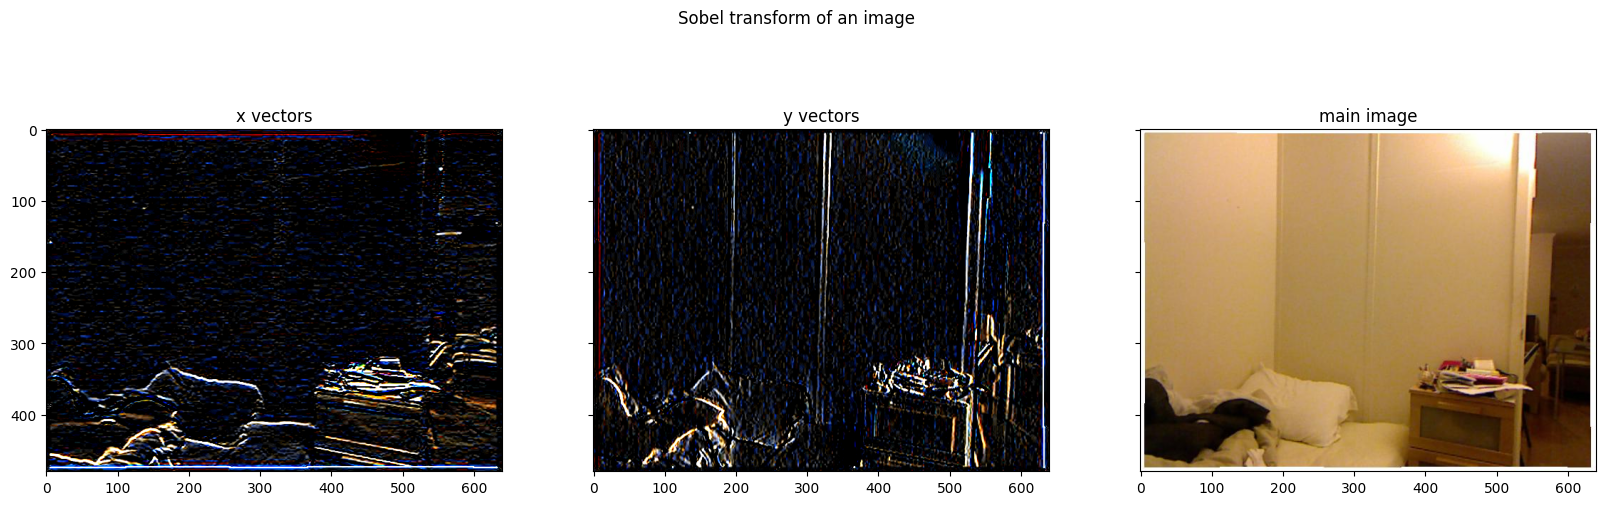

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
axs[0].imshow(x.transpose(1, 2, 0))
axs[0].title.set_text("x vectors")
axs[1].imshow(y.transpose(1, 2, 0))
axs[1].title.set_text("y vectors")
axs[2].imshow(tmp[0].permute(1, 2, 0))
axs[2].title.set_text("main image")
fig.suptitle("Sobel transform of an image")
plt.show()

Training loop

In [ ]:
for step in range(EPOCHS):
  current_loss = []
  last_loss = 0
  last_v_loss = 0

  for i in range(len(train_data)):

    data_batched = next(iter(train_data))
    for x_data, y_data in zip(data_batched[0], data_batched[1]):

      pool0, pool1, pool2, convolution0 = [], [], [], []

      x = x_data.to("cuda:0").unsqueeze(0)
      x.requires_grad = False
      y = torch.autograd.Variable(y_data).to("cuda:0").unsqueeze(0)
      y = 10 / y

      output = model(x)

      print(y.shape, output.shape)
      loss_function = custom_loss()
      loss = loss_function(y, output)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      current_loss.append(loss.item())

      # plotting loss per 100 step
    if(i % 100 == 0):
      torch.save(model.state_dict(), "/content/drive/MyDrive/depth/mdeinitial.pth")
      f"\t batch: {i} \t {current_loss[-1]}"
      plt.plot(current_loss)
      plt.show()

    # validation was not implemented
    # the model was evaluated based on loss and tested on a test data
  last_loss = torch.sum(current_loss) / 100
  print(f"Epoch {step}: loss {last_loss}")